# How RNNs, CNNs, and Attention Mechanisms Differ in Learning Text Sequences: An Empirical Tutorial.

### 1. Import required libraries.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Load and Preprocess the IMDb Dataset

We’ll use the built-in IMDb movie reviews (binary sentiment: positive/negative).

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 10000   # only keep top 10k most frequent words
MAX_LEN = 200        # cut or pad reviews to length 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

print("Train samples:", len(x_train))
print("Test samples:", len(x_test))
print("Example sequence:", x_train[0][:20], "...")
print("Label:", y_train[0])

Train samples: 25000
Test samples: 25000
Example sequence: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25] ...
Label: 1


### Pad sequences to fixed length:

In [8]:
x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding="post", truncating="post")
x_test = pad_sequences(x_test, maxlen=MAX_LEN, padding="post", truncating="post")

print("Padded train shape:", x_train.shape)
print("Padded test shape:", x_test.shape)

Padded train shape: (25000, 200)
Padded test shape: (25000, 200)


### Create a validation split from the training data:

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)

Train: (20000, 200) Val: (5000, 200) Test: (25000, 200)


### 3. Common Settings

We’ll share some hyperparameters between models:

In [12]:
EMBED_DIM = 64
BATCH_SIZE = 128
EPOCHS = 5

### 4. Define the Three Models
#### 4.1 RNN Model (LSTM)

In [14]:
def build_rnn_model():
    inputs = keras.Input(shape=(MAX_LEN,))
    x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN)(inputs)
    x = layers.LSTM(64)(x)  # can use GRU instead
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="RNN_LSTM")
    
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

rnn_model = build_rnn_model()
rnn_model.summary()

D:\Anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "RNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 675,137 (2.58 MB)

 Trainable params: 675,137 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.2 CNN Model (1D Convolution)

In [16]:
def build_cnn_model():
    inputs = keras.Input(shape=(MAX_LEN,))
    x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN)(inputs)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="CNN_1D")
    
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

Model: "CNN_1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 196, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 94, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 767,297 (2.93 MB)

 Trainable params: 767,297 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.3 Attention-Based Model (BiLSTM + Attention)

We’ll implement a simple attention pooling layer over the BiLSTM outputs.

In [18]:
class AttentionPooling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch, timesteps, features)
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(1,),
            initializer="zeros",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        # Compute unnormalised attention scores
        score = tf.matmul(inputs, self.W) + self.b  # (batch, timesteps, 1)
        score = tf.nn.tanh(score)
        score = tf.squeeze(score, axis=-1)  # (batch, timesteps)

        # Softmax over timesteps
        alpha = tf.nn.softmax(score, axis=1)  # (batch, timesteps)

        # Weighted sum of inputs
        alpha = tf.expand_dims(alpha, axis=-1)  # (batch, timesteps, 1)
        context = inputs * alpha               # (batch, timesteps, features)
        context = tf.reduce_sum(context, axis=1)  # (batch, features)
        return context

def build_attention_model():
    inputs = keras.Input(shape=(MAX_LEN,))
    x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN)(inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = AttentionPooling()(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="BiLSTM_Attention")
    
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

att_model = build_attention_model()
att_model.summary()


Model: "BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_pooling (AttentionPooling) │ (None, 128)                 │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 710,338 (2.71 MB)

 Trainable params: 710,338 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Train All Three Models

We’ll store histories in a dict for plotting later:

In [20]:
histories = {}

print("\n=== Training RNN (LSTM) model ===")
rnn_history = rnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)
histories["RNN"] = rnn_history.history

print("\n=== Training CNN model ===")
cnn_history = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)
histories["CNN"] = cnn_history.history

print("\n=== Training Attention-based model ===")
att_history = att_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)
histories["Attention"] = att_history.history


=== Training RNN (LSTM) model ===
Epoch 1/5
157/157 - 42s - 270ms/step - accuracy: 0.5178 - loss: 0.6920 - val_accuracy: 0.5412 - val_loss: 0.6896
Epoch 2/5
157/157 - 36s - 232ms/step - accuracy: 0.6497 - loss: 0.6339 - val_accuracy: 0.6718 - val_loss: 0.6317
Epoch 3/5
157/157 - 37s - 234ms/step - accuracy: 0.6835 - loss: 0.6090 - val_accuracy: 0.6346 - val_loss: 0.6238
Epoch 4/5
157/157 - 37s - 234ms/step - accuracy: 0.6223 - loss: 0.6278 - val_accuracy: 0.6484 - val_loss: 0.6199
Epoch 5/5
157/157 - 37s - 234ms/step - accuracy: 0.6105 - loss: 0.6431 - val_accuracy: 0.6044 - val_loss: 0.6530

=== Training CNN model ===
Epoch 1/5
157/157 - 18s - 114ms/step - accuracy: 0.7075 - loss: 0.5435 - val_accuracy: 0.8260 - val_loss: 0.3920
Epoch 2/5
157/157 - 14s - 92ms/step - accuracy: 0.8692 - loss: 0.3035 - val_accuracy: 0.8496 - val_loss: 0.3747
Epoch 3/5
157/157 - 15s - 94ms/step - accuracy: 0.9241 - loss: 0.1972 - val_accuracy: 0.8010 - val_loss: 0.5630
Epoch 4/5
157/157 - 15s - 94ms/step

### 6. Evaluate on the Test Set

In [22]:
def evaluate_model(model, name):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{name} - Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

evaluate_model(rnn_model, "RNN (LSTM)")
evaluate_model(cnn_model, "CNN")
evaluate_model(att_model, "BiLSTM + Attention")


RNN (LSTM) - Test Loss: 0.6566, Test Accuracy: 0.5885
CNN - Test Loss: 0.5706, Test Accuracy: 0.8293
BiLSTM + Attention - Test Loss: 0.3552, Test Accuracy: 0.8479


### 7. Plot Training vs Validation Curves.

#### 7.1 Accuracy Curves

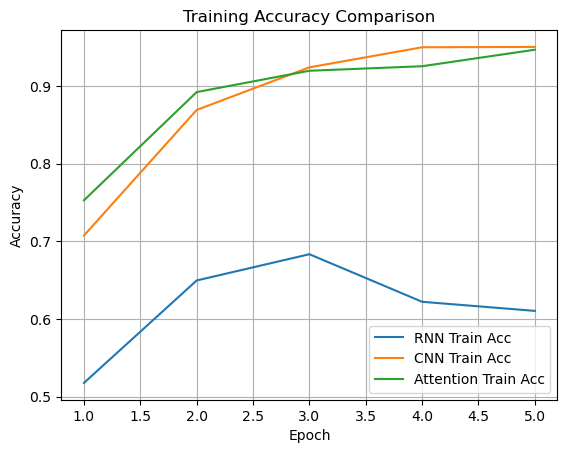

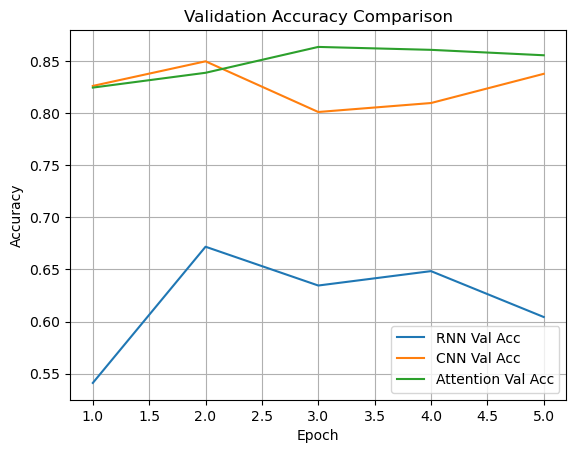

In [44]:
epochs = range(1, EPOCHS + 1)

plt.figure()
for name, hist in histories.items():
    plt.plot(epochs, hist["accuracy"], label=f"{name} Train Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig("Training_Accuracy_comparision.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for name, hist in histories.items():
    plt.plot(epochs, hist["val_accuracy"], label=f"{name} Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig("Validation_Accuracy_comparision.png", dpi=300, bbox_inches="tight")
plt.show()

### 7.2 Loss Curves

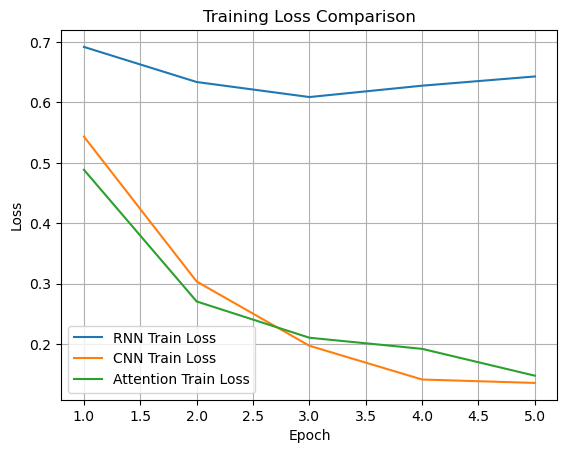

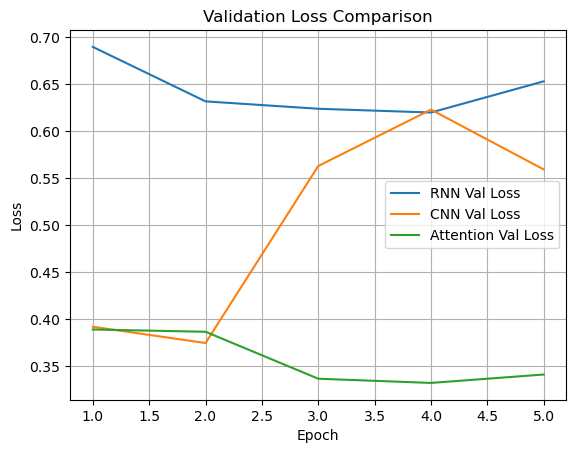

In [42]:
plt.figure()
for name, hist in histories.items():
    plt.plot(epochs, hist["loss"], label=f"{name} Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.savefig("Training_Loss_comparision.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for name, hist in histories.items():
    plt.plot(epochs, hist["val_loss"], label=f"{name} Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.savefig("Validation_Loss_comparision.png", dpi=300, bbox_inches="tight")
plt.show()